In [21]:
#!pip install dgl

In [56]:
%matplotlib inline

# Generative Models of Graphs

Jay Urbain, PhD
2/8/2023

Refeactored from: https://github.com/dmlc/dgl/tree/master/examples/pytorch/dgmg


===========================================

References: 

Learning Deep Generative Models of Graphs, https://arxiv.org/pdf/1803.03324.pdf

Mufei Li, https://github.com/mufeili

Lingfan Yu <https://github.com/ylfdq1118, Zheng Zhang


### Introduction

- Learn how to train and generate one graph at
a time. 

- Explore parallelism within the graph embedding operation. 

- Predict the future evolution of the graph and perform the analysis iteratively.

### Approach:  

Generate a variety of graph samples. In other words, you need
**generative models** of graphs. In-addition to learning
node and edge features, you need to model the distribution of arbitrary graphs.
While general generative models can model the density function explicitly and
implicitly and generate samples at once or sequentially, we only focus
on explicit generative models for sequential generation here. Typical applications
include drug or materials discovery, chemical processes, or proteomics.

The primitive actions of mutating a graph in Deep Graph Library (DGL) are nothing more than ``add_nodes``
and ``add_edges``. That is, if you were to draw a circle of three nodes,


In [84]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(1)              # Add node 0
g.add_nodes(1)              # Add node 1

# Edges in DGLGraph are directed by default.
# For undirected edges, add edges for both directions.
g.add_edges([1, 0], [0, 1]) # Add edges (1, 0), (0, 1)
g.add_nodes(1)              # Add node 2
g.add_edges([2, 1], [1, 2]) # Add edges (2, 1), (1, 2)
g.add_edges([2, 0], [0, 2]) # Add edges (2, 0), (0, 2)

<img src="48313438-78baf000-e5f7-11e8-931e-cd00ab34fa50.gif">

### Real-world graphs

Real-world graphs are much more complex. There are many families of graphs,
with different sizes, topologies, node types, edge types, and the possibility
of multigraphs. Besides, the same graph can be generated in many different
orders. The generative process entails a few steps.

- Encode a changing graph.
- Perform actions stochastically.
- If you are training, collect error signals and optimize the model parameters.

When it comes to implementation, another important aspect is speed. How do you
parallelize the computation, given that generating a graph is fundamentally a
sequential process?

Deep Generative Models of Graphs <https://arxiv.org/abs/1803.03324> (DGMG).

DGMG generates a graph by following a state machine, which is basically a
two-level loop. Generate one node at a time and connect it to a subset of
the existing nodes, one at a time. This is similar to language modeling. The
generative process is an iterative one that emits one word or character or sentence
at a time, conditioned on the sequence generated so far.

At each time step, you either:  
     - Add a new node to the graph  
     - Select two existing nodes and add an edge between them  


In [106]:
def forward_inference(self):
    stop = self.add_node_and_update()
    while (not stop) and (self.g.number_of_nodes() < self.v_max + 1):
        num_trials = 0
        to_add_edge = self.add_edge_or_not()
        while to_add_edge and (num_trials < self.g.number_of_nodes() - 1):
            self.choose_dest_and_update()
            num_trials += 1
            to_add_edge = self.add_edge_or_not()
        stop = self.add_node_and_update()

    return self.g

### DGMG: Optimization objective

Similar to language modeling, DGMG trains the model with *behavior cloning*,
or *teacher forcing*. Assume for each graph there exists a sequence of
*oracle actions* $a_{1},\cdots,a_{T}$ that generates it. What the model
does is to follow these actions, compute the joint probabilities of such
action sequences, and maximize them.

By chain rule, the probability of taking $a_{1},\cdots,a_{T}$ is:

$$p(a_{1},\cdots, a_{T}) = p(a_{1})p(a_{2}|a_{1})\cdots p(a_{T}|a_{1},\cdots,a_{T-1})$$

The optimization objective is then simply the typical MLE loss:

$$-\log p(a_{1},\cdots,a_{T})=-\sum_{t=1}^{T}\log p(a_{t}|a_{1},\cdots, a_{t-1})$$



In [107]:

def forward_train(self, actions):
    """
    - actions: list
        - Contains a_1, ..., a_T described above
    - self.prepare_for_train()
        - Initializes self.action_step to be 0, which will get
          incremented by 1 every time it is called.
        - Initializes objects recording log p(a_t|a_1,...a_{t-1})
    Returns
    -------
    - self.get_log_prob(): log p(a_1, ..., a_T)
    """
    self.prepare_for_train()

    stop = self.add_node_and_update(a=actions[self.action_step])
    while not stop:
        to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        while to_add_edge:
            self.choose_dest_and_update(a=actions[self.action_step])
            to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        stop = self.add_node_and_update(a=actions[self.action_step])

    return self.get_log_prob()

The key difference between ``forward_train`` and ``forward_inference`` is
that the training process takes oracle actions as input and returns log
probabilities for evaluating the loss.

### DGMG: The implementation

The ``DGMG`` class
``````````````````````````
Below you can find the skeleton code for the model. You gradually
fill in the details for each function.


In [108]:

import torch.nn as nn


class DGMGSkeleton(nn.Module):
    def __init__(self, v_max):
        """
        Parameters
        ----------
        v_max: int
            Max number of nodes considered
        """
        super(DGMGSkeleton, self).__init__()

        # Graph configuration
        self.v_max = v_max

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""
        return NotImplementedError

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""
        return NotImplementedError

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""
        return NotImplementedError

    def forward_train(self, actions):
        """Forward at training time. It records the probability
        of generating a ground truth graph following the actions."""
        return NotImplementedError

    def forward_inference(self):
        """Forward at inference time.
        It generates graphs on the fly."""
        return NotImplementedError

    def forward(self, actions=None):
        # The graph you will work on
        self.g = dgl.DGLGraph()

        # If there are some features for nodes and edges,
        # zero tensors will be set for those of new nodes and edges.
        self.g.set_n_initializer(dgl.frame.zero_initializer)
        self.g.set_e_initializer(dgl.frame.zero_initializer)

        if self.training:
            return self.forward_train(actions=actions)
        else:
            return self.forward_inference()

### Encoding a dynamic graph

All the actions generating a graph are sampled from probability
distributions. In order to do that, you project the structured data,
namely the graph, onto an Euclidean space. The challenge is that such
process, called *embedding*, needs to be repeated as the graphs mutate.

#### Graph embedding

Let $G=(V,E)$ be an arbitrary graph. Each node $v$ has an
embedding vector $\textbf{h}_{v} \in \mathbb{R}^{n}$. Similarly,
the graph has an embedding vector $\textbf{h}_{G} \in \mathbb{R}^{k}$.
Typically, $k > n$ since a graph contains more information than
an individual node.

The graph embedding is a weighted sum of node embeddings under a linear
transformation:

$$\textbf{h}_{G} =\sum_{v\in V}\text{Sigmoid}(g_m(\textbf{h}_{v}))f_{m}(\textbf{h}_{v})$$

The first term, $\text{Sigmoid}(g_m(\textbf{h}_{v}))$, computes a
gating function and can be thought of as how much the overall graph embedding
attends on each node. The second term $f_{m}:\mathbb{R}^{n}\rightarrow\mathbb{R}^{k}$
maps the node embeddings to the space of graph embeddings.

Implement graph embedding as a ``GraphEmbed`` class.



In [66]:

import torch


class GraphEmbed(nn.Module):
    def __init__(self, node_hidden_size):
        super(GraphEmbed, self).__init__()

        # Setting from the paper
        self.graph_hidden_size = 2 * node_hidden_size

        # Embed graphs
        self.node_gating = nn.Sequential(
            nn.Linear(node_hidden_size, 1),
            nn.Sigmoid()
        )
        self.node_to_graph = nn.Linear(node_hidden_size,
                                       self.graph_hidden_size)

    def forward(self, g):
        if g.number_of_nodes() == 0:
            return torch.zeros(1, self.graph_hidden_size)
        else:
            # Node features are stored as hv in ndata.
            hvs = g.ndata['hv']
            return (self.node_gating(hvs) *
                    self.node_to_graph(hvs)).sum(0, keepdim=True)

### Update node embeddings via graph propagation

The mechanism of updating node embeddings in DGMG is similar to that for
graph convolutional networks. For a node $v$ in the graph, its
neighbor $u$ sends a message to it with

$$\textbf{m}_{u\rightarrow v}=\textbf{W}_{m}\text{concat}([\textbf{h}_{v}, \textbf{h}_{u}, \textbf{x}_{u, v}]) + \textbf{b}_{m}$$

$\textbf{x}_{u,v}$ is the embedding of the edge between
$u$ and $v$.

After receiving messages from all its neighbors, $v$ summarizes them
with a node activation vector

$$\textbf{a}_{v} = \sum_{u: (u, v)\in E}\textbf{m}_{u\rightarrow v}$$

and use this information to update its own feature:

$$\textbf{h}'_{v} = \textbf{GRU}(\textbf{h}_{v}, \textbf{a}_{v})$$

Performing all the operations above once for all nodes synchronously is
called one round of graph propagation. The more rounds of graph propagation
you perform, the longer distance messages travel throughout the graph.

With DGL, you implement graph propagation with ``g.update_all``.
The message notation here can be a bit confusing. Researchers can refer
to $\textbf{m}_{u\rightarrow v}$ as messages, however the message function
below only passes $\text{concat}([\textbf{h}_{u}, \textbf{x}_{u, v}])$.
The operation $\textbf{W}_{m}\text{concat}([\textbf{h}_{v}, \textbf{h}_{u}, \textbf{x}_{u, v}]) + \textbf{b}_{m}$
is then performed across all edges at once for efficiency consideration.



In [98]:

from functools import partial

class GraphProp(nn.Module):
    def __init__(self, num_prop_rounds, node_hidden_size):
        super(GraphProp, self).__init__()

        self.num_prop_rounds = num_prop_rounds

        # Setting from the paper
        self.node_activation_hidden_size = 2 * node_hidden_size

        message_funcs = []
        node_update_funcs = []
        self.reduce_funcs = []

        for t in range(num_prop_rounds):
            # input being [hv, hu, xuv]
            message_funcs.append(nn.Linear(2 * node_hidden_size + 1,
                                           self.node_activation_hidden_size))

            self.reduce_funcs.append(partial(self.dgmg_reduce, round=t))
            node_update_funcs.append(
                nn.GRUCell(self.node_activation_hidden_size,
                           node_hidden_size))

        self.message_funcs = nn.ModuleList(message_funcs)
        self.node_update_funcs = nn.ModuleList(node_update_funcs)

    def dgmg_msg(self, edges):
        """For an edge u->v, return concat([h_u, x_uv])"""
        return {'m': torch.cat([edges.src['hv'],
                                edges.data['he']],
                               dim=1)}

    def dgmg_reduce(self, nodes, round):
        hv_old = nodes.data['hv']
        m = nodes.mailbox['m']
        message = torch.cat([
            hv_old.unsqueeze(1).expand(-1, m.size(1), -1), m], dim=2)
        node_activation = (self.message_funcs[round](message)).sum(1)

        return {'a': node_activation}

    def forward(self, g):
        if g.number_of_edges() > 0:
            for t in range(self.num_prop_rounds):
                g.update_all(message_func=self.dgmg_msg,
                             reduce_func=self.reduce_funcs[t])
                g.ndata['hv'] = self.node_update_funcs[t](
                     g.ndata['a'], g.ndata['hv'])


## Actions

All actions are sampled from distributions parameterized using neural networks
and here they are in turn.

### Action 1: Add nodes

Given the graph embedding vector $\textbf{h}_{G}$, evaluate 
$$\text{Sigmoid}(\textbf{W}_{\text{add node}}\textbf{h}_{G}+b_{\text{add node}})$$.

which is then used to parameterize a Bernoulli distribution for deciding whether
to add a new node.

If a new node is to be added, initialize its feature with

$\textbf{W}_{\text{init}}\text{concat}([\textbf{h}_{\text{init}} , \textbf{h}_{G}])+\textbf{b}_{\text{init}} $

where $\textbf{h}_{\text{init}}$ is a learnable embedding module for
untyped nodes.


In [99]:
import torch.nn.functional as F
from torch.distributions import Bernoulli

def bernoulli_action_log_prob(logit, action):
    """Calculate the log p of an action with respect to a Bernoulli
    distribution. Use logit rather than prob for numerical stability."""
    if action == 0:
        return F.logsigmoid(-logit)
    else:
        return F.logsigmoid(logit)

class AddNode(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddNode, self).__init__()

        self.graph_op = {'embed': graph_embed_func}

        self.stop = 1
        self.add_node = nn.Linear(graph_embed_func.graph_hidden_size, 1)

        # If to add a node, initialize its hv
        self.node_type_embed = nn.Embedding(1, node_hidden_size)
        self.initialize_hv = nn.Linear(node_hidden_size + \
                                       graph_embed_func.graph_hidden_size,
                                       node_hidden_size)

        self.init_node_activation = torch.zeros(1, 2 * node_hidden_size)

    def _initialize_node_repr(self, g, node_type, graph_embed):
        """Whenver a node is added, initialize its representation."""
        num_nodes = g.number_of_nodes()
        hv_init = self.initialize_hv(
            torch.cat([
                self.node_type_embed(torch.LongTensor([node_type])),
                graph_embed], dim=1))
        g.nodes[num_nodes - 1].data['hv'] = hv_init
        g.nodes[num_nodes - 1].data['a'] = self.init_node_activation

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)

        logit = self.add_node(graph_embed)
        prob = torch.sigmoid(logit)

        if not self.training:
            action = Bernoulli(prob).sample().item()
        stop = bool(action == self.stop)

        if not stop:
            g.add_nodes(1)
            self._initialize_node_repr(g, action, graph_embed)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)

            self.log_prob.append(sample_log_prob)

        return stop


### Action 2: Add edges

Given the graph embedding vector $\textbf{h}_{G}$ and the node
embedding vector $\textbf{h}_{v}$ for the latest node $v$
 evaluate

$$\text{Sigmoid}(\textbf{W}_{\text{add edge}}\text{concat}([\textbf{h}_{G}, \textbf{h}_{v}])+b_{\text{add edge}})$$

which is then used to parametrize a Bernoulli distribution for deciding
whether to add a new edge starting from $v$


In [100]:
class AddEdge(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddEdge, self).__init__()

        self.graph_op = {'embed': graph_embed_func}
        self.add_edge = nn.Linear(graph_embed_func.graph_hidden_size + \
                                  node_hidden_size, 1)

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)
        src_embed = g.nodes[g.number_of_nodes() - 1].data['hv']

        logit = self.add_edge(torch.cat(
            [graph_embed, src_embed], dim=1))
        prob = torch.sigmoid(logit)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)
            self.log_prob.append(sample_log_prob)
        else:
            action = Bernoulli(prob).sample().item()

        to_add_edge = bool(action == 0)
        return to_add_edge

### Action 3: Choose a destination

When action 2 returns `True`, choose a destination for the
latest node $v$.

$u\in\{0, \cdots, v-1\}$, the
probability of choosing it is given by

$$\frac{\text{exp}(\textbf{W}_{\text{dest}}\text{concat}([\textbf{h}_{u}, \textbf{h}_{v}])+\textbf{b}_{\text{dest}})}{\sum_{i=0}^{v-1}\text{exp}(\textbf{W}_{\text{dest}}\text{concat}([\textbf{h}_{i}, \textbf{h}_{v}])+\textbf{b}_{\text{dest}})}$$



In [101]:

from torch.distributions import Categorical

class ChooseDestAndUpdate(nn.Module):
    def __init__(self, graph_prop_func, node_hidden_size):
        super(ChooseDestAndUpdate, self).__init__()

        self.graph_op = {'prop': graph_prop_func}
        self.choose_dest = nn.Linear(2 * node_hidden_size, 1)

    def _initialize_edge_repr(self, g, src_list, dest_list):
        # For untyped edges, only add 1 to indicate its existence.
        # For multiple edge types, use a one-hot representation
        # or an embedding module.
        edge_repr = torch.ones(len(src_list), 1)
        g.edges[src_list, dest_list].data['he'] = edge_repr

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, dest):
        src = g.number_of_nodes() - 1
        possible_dests = range(src)

        src_embed_expand = g.nodes[src].data['hv'].expand(src, -1)
        possible_dests_embed = g.nodes[possible_dests].data['hv']

        dests_scores = self.choose_dest(
            torch.cat([possible_dests_embed,
                       src_embed_expand], dim=1)).view(1, -1)
        dests_probs = F.softmax(dests_scores, dim=1)

        if not self.training:
            dest = Categorical(dests_probs).sample().item()

        if not g.has_edges_between(src, dest):
            # For undirected graphs, add edges for both directions
            # so that you can perform graph propagation.
            src_list = [src, dest]
            dest_list = [dest, src]

            g.add_edges(src_list, dest_list)
            self._initialize_edge_repr(g, src_list, dest_list)

            self.graph_op['prop'](g)

        if self.training:
            if dests_probs.nelement() > 1:
                self.log_prob.append(
                    F.log_softmax(dests_scores, dim=1)[:, dest: dest + 1])

### Putting together a complete implementation of the model class.


In [102]:
class DGMG(DGMGSkeleton):
    def __init__(self, v_max, node_hidden_size,
                 num_prop_rounds):
        super(DGMG, self).__init__(v_max)

        # Graph embedding module
        self.graph_embed = GraphEmbed(node_hidden_size)

        # Graph propagation module
        self.graph_prop = GraphProp(num_prop_rounds,
                                    node_hidden_size)

        # Actions
        self.add_node_agent = AddNode(
            self.graph_embed, node_hidden_size)
        self.add_edge_agent = AddEdge(
            self.graph_embed, node_hidden_size)
        self.choose_dest_agent = ChooseDestAndUpdate(
            self.graph_prop, node_hidden_size)

        # Forward functions
        self.forward_train = partial(forward_train, self=self)
        self.forward_inference = partial(forward_inference, self=self)

    @property
    def action_step(self):
        old_step_count = self.step_count
        self.step_count += 1

        return old_step_count

    def prepare_for_train(self):
        self.step_count = 0

        self.add_node_agent.prepare_training()
        self.add_edge_agent.prepare_training()
        self.choose_dest_agent.prepare_training()

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""

        return self.add_node_agent(self.g, a)

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""

        return self.add_edge_agent(self.g, a)

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""

        self.choose_dest_agent(self.g, a)

    def get_log_prob(self):
        add_node_log_p = torch.cat(self.add_node_agent.log_prob).sum()
        add_edge_log_p = torch.cat(self.add_edge_agent.log_prob).sum()
        choose_dest_log_p = torch.cat(self.choose_dest_agent.log_prob).sum()
        return add_node_log_p + add_edge_log_p + choose_dest_log_p

In [103]:
# For generative models, you can evaluate performance by checking the percentage
# of valid graphs among the graphs it generates on the fly.

import torch.utils.model_zoo as model_zoo

# Download a pre-trained model state dict for generating cycles with 10-20 nodes.
state_dict = model_zoo.load_url('https://data.dgl.ai/model/dgmg_cycles-5a0c40be.pth')
model = DGMG(v_max=20, node_hidden_size=16, num_prop_rounds=2)
model.load_state_dict(state_dict)
model.eval()

def is_valid(g):
    # Check if g is a cycle having 10-20 nodes.
    def _get_previous(i, v_max):
        if i == 0:
            return v_max
        else:
            return i - 1

    def _get_next(i, v_max):
        if i == v_max:
            return 0
        else:
            return i + 1

    size = g.number_of_nodes()

    if size < 10 or size > 20:
        return False

    for node in range(size):
        neighbors = g.successors(node)

        if len(neighbors) != 2:
            return False

        if _get_previous(node, size - 1) not in neighbors:
            return False

        if _get_next(node, size - 1) not in neighbors:
            return False

    return True

num_valid = 0
for i in range(100):
    g = model()
    num_valid += is_valid(g)

# del model
torch.save(model, './model.pth')
print('Among 100 graphs generated, {}% are valid.'.format(num_valid))

/var/folders/72/m1_77lk923306pr7qrrd7l100000gn/T/ipykernel_28922/1515154086.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.node_type_embed(torch.LongTensor([node_type])),


Among 100 graphs generated, 91% are valid.


### Generate a cycle on-the-fly during inference.

Assume you have a pre-trained model for generating cycles of nodes 10-20.


In [96]:
%matplotlib notebook

nx_g.nodes() []
nx_g.nodes() [0, 1]
nx_g.nodes() [0, 1, 2]
nx_g.nodes() [0, 1, 2, 3]
nx_g.nodes() [0, 1, 2, 3, 4]
nx_g.nodes() [0, 1, 2, 3, 4, 5]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
nx_g.nodes() [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


/var/folders/72/m1_77lk923306pr7qrrd7l100000gn/T/ipykernel_28922/1515154086.py:34: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.node_type_embed(torch.LongTensor([node_type])),


<IPython.core.display.Javascript object>


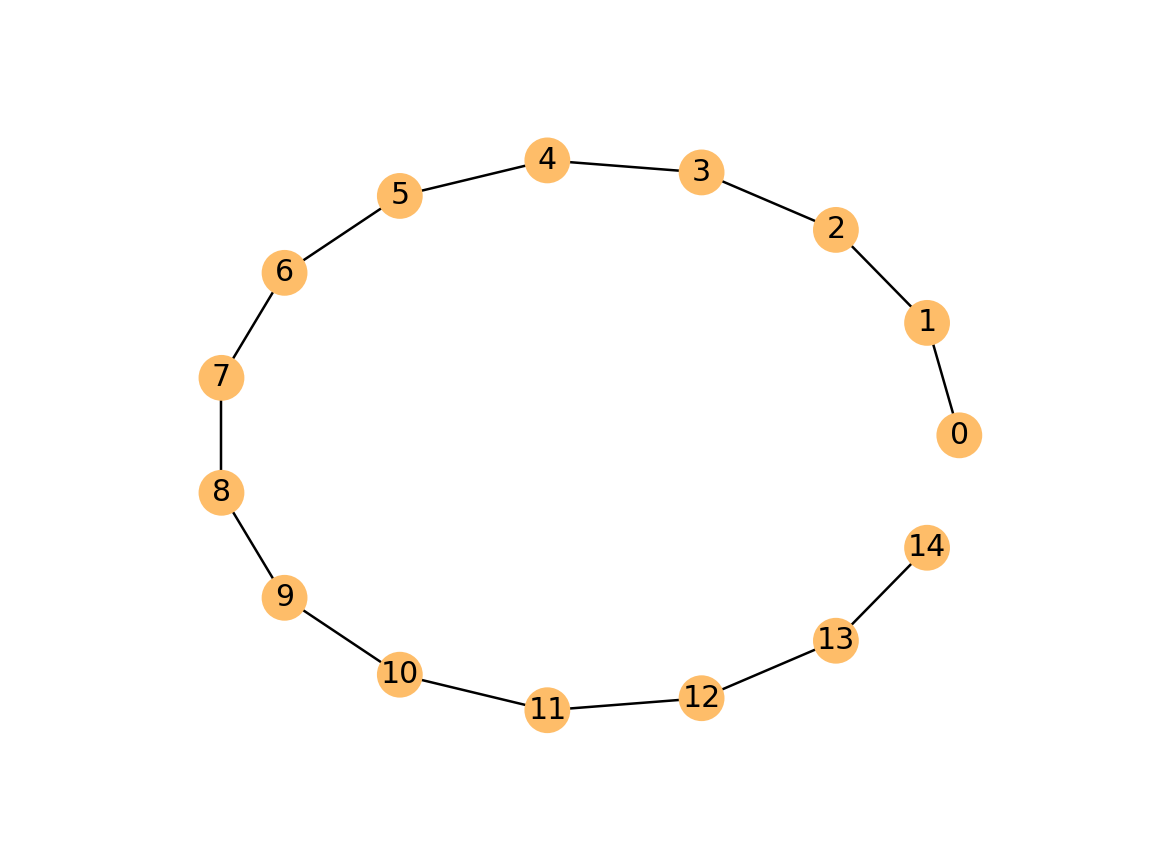

In [97]:
import torch
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy

# if __name__ == '__main__':
# pre-trained model saved with path ./model.pth
model = torch.load('./model.pth')
model.eval()
g = model()

src_list = g.edges()[1]
dest_list = g.edges()[0]

evolution = []

nx_g = nx.Graph()
evolution.append(deepcopy(nx_g))

for i in range(0, len(src_list), 2):
    print('nx_g.nodes()', nx_g.nodes())
    src = src_list[i].item()
    dest = dest_list[i].item()
    if src not in nx_g.nodes():
        nx_g.add_node(src)
        evolution.append(deepcopy(nx_g))
    if dest not in nx_g.nodes():
        nx_g.add_node(dest)
        evolution.append(deepcopy(nx_g))
    nx_g.add_edges_from([(src, dest), (dest, src)])
    evolution.append(deepcopy(nx_g))

def animate(i):
    ax.cla()
    g_t = evolution[i]
    print(g_t)
    nx.draw_circular(g_t, with_labels=True, ax=ax,
                     node_color=['#FEBD69'] * g_t.number_of_nodes())

fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, animate,
                              frames=len(evolution),
                              interval=600)
